In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os

In [2]:
team_csvs = []
Team_1420_dfs = []
years = ['/2014', '/2015', '/2016', '/2017', '/2018', '/2019', '/2020']
for year in years[:-1]:
    year = year[1:]
    for entry in os.scandir('Understat_Team_Data/EPL_teams' + '/{}'.format(year)):
        if entry.is_file():
            df = pd.read_csv('Understat_Team_Data/EPL_teams' + '/{}'.format(year) + '/{}'.format(entry.name))
            for col in list(df.columns):
                if 'Unnamed' in col:
                    del df[col]       
            Team_1420_dfs.append(df)
big_team_df = pd.concat(Team_1420_dfs, ignore_index=True)
big_team_df.to_csv('All_Epl_dfs_1420.csv')

In [3]:
OG_cols = ['Home/Away','xG','xGA','non-penalty xG','non-penalty xG Against','Deep','Deep Allowed','scored','conceded',
 'Expected Points','Result','date','Wins','Draws','Loses','Points','Non-penalty xG difference','ppda attack','ppda defence',
 'ppda allowed att','ppda allowed def','Wins cum','Loses cum','Draws cum','Points cum','npxG difference cum','xG cum','xGA cum',
 'npxG cum','npxGA cum','scored cum', 'conceded cum', 'Expected Points cum','Opponent','Prob Win',
 'Prob Draw','Prob Lose','Wins in last 5','Loses in last 5','Draws in last 5','Points in last 5','npxG difference last 5',
           'xG last 5','xGA last 5','npxG last 5','npxGA last 5','scored last 5','conceded last 5','Expected Points last 5']
prev_game_cols = []
for col in OG_cols:
    prev_game_cols.append('Prev game ' + col)

MAKING THE TRAINING TEST SET

In [4]:
big_team_df = pd.read_csv('All_Epl_dfs_1420.csv')
#Make a df with JUST opponent data as well as the probabilities of win/lose/draw
for col in list(big_team_df.columns):
    if ('Opp' not in col) and ('Prob ' not in col):
        del big_team_df[col]
        
#Make the next one, where we keep the Team stat side of the dataframe, moving it to be the previous game.
big_team_df_2 = pd.DataFrame(index = [0], columns=big_team_df.columns)
big_team_df_2 = big_team_df_2.fillna(0)
for dataframe in Team_1420_dfs:
    jeff = []
    #Make the first line 0s 
    df_ = pd.DataFrame(index = [0], columns=big_team_df.columns)
    df_ = df_.fillna(0)
    #Get the above with the other lines of the dataframe
    jeff.append(df_)
    jeff.append(dataframe.drop(index = 37))
    #put all of these together
    jeff_concat = pd.concat(jeff, ignore_index = True)
    big_team_df_2 = pd.concat([big_team_df_2, jeff_concat], ignore_index = True)
big_team_df_2 = big_team_df_2.drop(index = 0)

#Delete all of the opponent columns/ probability columns
for col in list(big_team_df_2.columns):
    if ('Opp' in col) or ('Prob ' in col):
        del big_team_df_2[col]

prev_game_dict = {OG_cols[i]: prev_game_cols[i] for i in range(len(OG_cols))}
del prev_game_dict['Home/Away']
B_df_2 = big_team_df_2.rename(columns = prev_game_dict, inplace = False)
B_df_3 = pd.concat([B_df_2, big_team_df], axis = 1)

B_df_3 = B_df_3.dropna()

B_df_3['% Win'] = 100*B_df_3['Prob Win']
B_df_3['% Draw']= 100*B_df_3['Prob Draw']
B_df_3['% Lose']= 100*B_df_3['Prob Lose']
#Making sure the dataframe's columns are suitable for the model
h_a_dict = { 'h': 1, 'a' : -1}
def h_a_numbs(loc):
    return h_a_dict[loc]
B_df_3['Home/Away'] = B_df_3['Home/Away'].apply(h_a_numbs)

USING THE ARSENAL 20/21 SET TO VALIDATE OUR DATA

In [5]:
df = pd.read_csv('Understat_Team_Data/EPL_teams/2020/Arsenal.csv')
for col in list(df.columns):
    if ('Opp' not in col) and ('Prob ' not in col):
        del df[col]
#Previous Game data
df_1 = pd.read_csv('Understat_Team_Data/EPL_teams/2020/Arsenal.csv')
df_ = pd.DataFrame(index = [0], columns=df.columns)
df_ = df_.fillna(0)
df_2 = pd.concat([df_, df_1.drop(index = 37)], ignore_index=True)
for col in list(df_2.columns):
    if ('Opp' in col) or ('Prob ' in col) or ('Unnamed' in col):
        del df_2[col]
prev_game_dict = {OG_cols[i]: prev_game_cols[i] for i in range(len(OG_cols))}
del prev_game_dict['Home/Away']
df_2 = df_2.rename(columns = prev_game_dict, inplace = False)
#Combining and making probabilities into percentages
Arsenal_2021_df = pd.concat([df_2, df], axis = 1)
Arsenal_2021_df = Arsenal_2021_df.drop(index = 0)
Arsenal_2021_df['% Win'] = 100*Arsenal_2021_df['Prob Win']
Arsenal_2021_df['% Draw']= 100*Arsenal_2021_df['Prob Draw']
Arsenal_2021_df['% Lose']= 100*Arsenal_2021_df['Prob Lose']
Arsenal_2021_df['Home/Away'] = Arsenal_2021_df['Home/Away'].apply(h_a_numbs)

Splitting into test/train

In [9]:
#Predicting 2020/21 season results from 2014-2020 results
cols = []
for col in list(B_df_3.columns):
    if type(B_df_3[col][2]) != str:
        cols.append(col)
cols.remove(cols[43])
cols.remove(cols[43])
cols.remove(cols[43])
cols = cols[:-3]
#cols.remove(cols[-2])
#cols.remove(cols[-2])
#cols.remove(cols[-2])
pred = ['% Win', '% Draw', '% Lose']
train_y = B_df_3['% Win']
train_X = B_df_3[cols]
val_y = Arsenal_2021_df['% Win']
val_X = Arsenal_2021_df[cols]

###This is optional

In [13]:
#Applying Scaling to the model, preprocessing the data
sc = StandardScaler()
sc.fit(train_X)
scaled_train_X = sc.transform(train_X)
scaled_val_X = sc.transform(val_X)

In [10]:
pca = PCA(n_components = 30)

In [14]:
pca.fit(scaled_train_X)

PCA(n_components=30)

In [19]:
X_pca = pca.transform(scaled_train_X)

In [23]:
X_pca_val = pca.transform(scaled_val_X)

In [16]:
scaled_train_X.shape

(4439, 88)

In [17]:
x_pca.shape

(4439, 30)

This is not

In [65]:
print(len(list(train_X)))

88


In [80]:
print(len(list(val_X)))

88


In [ ]:
# Let's try making a Neural Network! (Without PCA)
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20, 
    restore_best_weights=True,
)

NN_model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[88]),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1),
])

NN_model.compile(
    optimizer='adam',
    loss='mae',
)

history = NN_model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=190,
    epochs=100,
    verbose = 1,
    shuffle = True
)

In [25]:
# Let's try making a Neural Network! (With PCA)
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20, 
    restore_best_weights=True,
)

NN_model_pca = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[30]),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(8, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(1),
])

NN_model_pca.compile(
    optimizer='adam',
    loss='mae',
)

history = NN_model_pca.fit(
    X_pca, train_y,
    validation_data=(X_pca_val, val_y),
    batch_size=190,
    epochs=100,
    verbose = 1,
    shuffle = True
)

Epoch 1/100
24/24 [==============================] - 0s 8ms/step - loss: 38.3141 - val_loss: 42.3138
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 38.1803 - val_loss: 42.2558
Epoch 3/100
24/24 [==============================] - 0s 2ms/step - loss: 38.0475 - val_loss: 42.1436
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 37.9022 - val_loss: 41.9876
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 37.7403 - val_loss: 41.7422
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 37.5498 - val_loss: 41.4504
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 37.3573 - val_loss: 41.1658
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 37.1403 - val_loss: 40.8706
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 36.8973 - val_loss: 40.5739
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 36.6442 - val_los

24/24 [==============================] - 0s 4ms/step - loss: 20.7312 - val_loss: 23.2849
Epoch 82/100
24/24 [==============================] - 0s 4ms/step - loss: 20.8209 - val_loss: 23.1664
Epoch 83/100
24/24 [==============================] - 0s 4ms/step - loss: 20.7636 - val_loss: 23.0321
Epoch 84/100
24/24 [==============================] - 0s 3ms/step - loss: 20.7271 - val_loss: 23.0881
Epoch 85/100
24/24 [==============================] - 0s 3ms/step - loss: 20.7352 - val_loss: 23.1075
Epoch 86/100
24/24 [==============================] - 0s 3ms/step - loss: 20.7163 - val_loss: 23.1404
Epoch 87/100
24/24 [==============================] - 0s 3ms/step - loss: 20.6236 - val_loss: 23.1060
Epoch 88/100
24/24 [==============================] - 0s 3ms/step - loss: 20.5864 - val_loss: 23.0633
Epoch 89/100
24/24 [==============================] - 0s 3ms/step - loss: 20.6344 - val_loss: 23.0592
Epoch 90/100
24/24 [==============================] - ETA: 0s - loss: 20.55 - 0s 3ms/step - los

In [ ]:
print(history_df)

In [ ]:
#Plot shit
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();

In [ ]:
pred = np.array([val_X])

In [ ]:
prediction = NN_model.predict(pred, verbose = 0)
print(prediction)

In [86]:
pwr_twos = [2 ** i for i in range(1, 11)]

In [95]:
mult_38 = [i * 38 for i in range(1,6)]

In [98]:
drp_rate = [ 1 / i for i in range(2, 10)]

The Latter took fucking ages to run so find smth to do in the background

In [26]:
pca_dims = [10,20,30,40,50]

Epoch 1/500
24/24 [==============================] - 0s 7ms/step - loss: 38.2983 - val_loss: 42.2956
Epoch 2/500
24/24 [==============================] - 0s 3ms/step - loss: 38.2200 - val_loss: 42.1498
Epoch 3/500
24/24 [==============================] - 0s 3ms/step - loss: 38.1245 - val_loss: 41.9959
Epoch 4/500
24/24 [==============================] - 0s 3ms/step - loss: 38.0169 - val_loss: 41.8398
Epoch 5/500
24/24 [==============================] - 0s 3ms/step - loss: 37.8828 - val_loss: 41.6645
Epoch 6/500
24/24 [==============================] - 0s 3ms/step - loss: 37.7295 - val_loss: 41.4645
Epoch 7/500
24/24 [==============================] - 0s 3ms/step - loss: 37.5552 - val_loss: 41.2708
Epoch 8/500
24/24 [==============================] - 0s 3ms/step - loss: 37.3667 - val_loss: 41.0805
Epoch 9/500
24/24 [==============================] - 0s 3ms/step - loss: 37.1445 - val_loss: 40.8432
Epoch 10/500
24/24 [==============================] - 0s 3ms/step - loss: 36.9080 - val_los

24/24 [==============================] - 0s 3ms/step - loss: 20.8154 - val_loss: 23.8074
Epoch 82/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4536 - val_loss: 23.7655
Epoch 83/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4941 - val_loss: 23.8314
Epoch 84/500
24/24 [==============================] - 0s 3ms/step - loss: 20.5043 - val_loss: 23.6761
Epoch 85/500
24/24 [==============================] - 0s 3ms/step - loss: 20.5867 - val_loss: 23.6437
Epoch 86/500
24/24 [==============================] - 0s 3ms/step - loss: 20.6927 - val_loss: 23.5781
Epoch 87/500
24/24 [==============================] - 0s 3ms/step - loss: 20.6423 - val_loss: 23.5714
Epoch 88/500
24/24 [==============================] - 0s 3ms/step - loss: 20.5759 - val_loss: 23.5013
Epoch 89/500
24/24 [==============================] - 0s 3ms/step - loss: 20.5857 - val_loss: 23.4042
Epoch 90/500
24/24 [==============================] - 0s 3ms/step - loss: 20.6097 - val_loss: 2

Epoch 161/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3105 - val_loss: 22.6053
Epoch 162/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2940 - val_loss: 22.5545
Epoch 163/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3350 - val_loss: 22.5859
Epoch 164/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2593 - val_loss: 22.6778
Epoch 165/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1066 - val_loss: 22.4751
Epoch 166/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3252 - val_loss: 22.4282
Epoch 167/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3085 - val_loss: 22.4294
Epoch 168/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3415 - val_loss: 22.4850
Epoch 169/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1222 - val_loss: 22.5088
Epoch 170/500
24/24 [==============================] - 0s 3ms/step - loss

24/24 [==============================] - 0s 3ms/step - loss: 19.9920 - val_loss: 21.8144
Epoch 241/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1746 - val_loss: 21.8830
Epoch 242/500
24/24 [==============================] - 0s 2ms/step - loss: 20.1784 - val_loss: 21.9121
Epoch 243/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1665 - val_loss: 21.9100
Epoch 244/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0860 - val_loss: 21.9366
Epoch 245/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9227 - val_loss: 21.9948
Epoch 246/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9021 - val_loss: 21.9736
Epoch 247/500
24/24 [==============================] - 0s 2ms/step - loss: 20.0446 - val_loss: 22.0325
Epoch 248/500
24/24 [==============================] - 0s 2ms/step - loss: 20.1200 - val_loss: 21.9467
Epoch 249/500
24/24 [==============================] - 0s 2ms/step - loss: 20.2141 - va

24/24 [==============================] - 0s 3ms/step - loss: 19.9952 - val_loss: 21.9607
Epoch 320/500
24/24 [==============================] - 0s 4ms/step - loss: 20.0589 - val_loss: 21.7821
Epoch 321/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8693 - val_loss: 21.7614
Epoch 322/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0868 - val_loss: 21.9221
Epoch 323/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1154 - val_loss: 22.0270
Epoch 324/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0130 - val_loss: 21.9031
Epoch 325/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0510 - val_loss: 21.9954
Epoch 326/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0901 - val_loss: 21.8629
Epoch 327/500
24/24 [==============================] - 0s 2ms/step - loss: 20.0250 - val_loss: 22.0617
Epoch 328/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9364 - va

24/24 [==============================] - 0s 2ms/step - loss: 19.7710 - val_loss: 21.6149
Epoch 399/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9409 - val_loss: 21.3995
Epoch 400/500
24/24 [==============================] - 0s 2ms/step - loss: 20.1310 - val_loss: 21.5273
Epoch 401/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9506 - val_loss: 21.5370
Epoch 402/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9717 - val_loss: 21.8885
Epoch 403/500
24/24 [==============================] - 0s 3ms/step - loss: 19.7173 - val_loss: 21.9854
Epoch 404/500
24/24 [==============================] - 0s 2ms/step - loss: 19.8340 - val_loss: 21.7580
Epoch 405/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9355 - val_loss: 22.0108
Epoch 406/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0900 - val_loss: 22.0643
Epoch 407/500
24/24 [==============================] - 0s 2ms/step - loss: 19.7506 - va

24/24 [==============================] - 0s 3ms/step - loss: 19.8458 - val_loss: 21.2095
Epoch 478/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8465 - val_loss: 21.2307
Epoch 479/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8960 - val_loss: 21.1884
Epoch 480/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0605 - val_loss: 21.4949
Epoch 481/500
24/24 [==============================] - 0s 2ms/step - loss: 19.8633 - val_loss: 21.4263
Epoch 482/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9672 - val_loss: 21.4486
Epoch 483/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8005 - val_loss: 21.6329
Epoch 484/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9313 - val_loss: 21.6285
Epoch 485/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9511 - val_loss: 21.5437
Epoch 486/500
24/24 [==============================] - 0s 2ms/step - loss: 20.1069 - va

24/24 [==============================] - 0s 2ms/step - loss: 22.6726 - val_loss: 25.4018
Epoch 54/500
24/24 [==============================] - 0s 2ms/step - loss: 22.3402 - val_loss: 25.3059
Epoch 55/500
24/24 [==============================] - 0s 2ms/step - loss: 22.2045 - val_loss: 25.0327
Epoch 56/500
24/24 [==============================] - 0s 3ms/step - loss: 21.9183 - val_loss: 24.9364
Epoch 57/500
24/24 [==============================] - 0s 3ms/step - loss: 22.0199 - val_loss: 24.6960
Epoch 58/500
24/24 [==============================] - 0s 2ms/step - loss: 21.8505 - val_loss: 24.4340
Epoch 59/500
24/24 [==============================] - 0s 2ms/step - loss: 21.6565 - val_loss: 24.3171
Epoch 60/500
24/24 [==============================] - 0s 2ms/step - loss: 21.4182 - val_loss: 24.1361
Epoch 61/500
24/24 [==============================] - 0s 2ms/step - loss: 21.5915 - val_loss: 24.1487
Epoch 62/500
24/24 [==============================] - 0s 3ms/step - loss: 21.4850 - val_loss: 2

24/24 [==============================] - 0s 3ms/step - loss: 20.4219 - val_loss: 22.1866
Epoch 134/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2219 - val_loss: 22.2328
Epoch 135/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3295 - val_loss: 22.2309
Epoch 136/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2384 - val_loss: 22.3432
Epoch 137/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3606 - val_loss: 22.2607
Epoch 138/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3640 - val_loss: 22.3720
Epoch 139/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4848 - val_loss: 22.3055
Epoch 140/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2899 - val_loss: 22.2006
Epoch 141/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2939 - val_loss: 22.1294
Epoch 142/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1886 - va

24/24 [==============================] - 0s 3ms/step - loss: 20.1977 - val_loss: 21.6439
Epoch 213/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3128 - val_loss: 21.5145
Epoch 214/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9753 - val_loss: 21.6411
Epoch 215/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0588 - val_loss: 21.4685
Epoch 216/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0929 - val_loss: 21.3284
Epoch 217/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1581 - val_loss: 21.5761
Epoch 218/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1624 - val_loss: 21.9096
Epoch 219/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1242 - val_loss: 21.6851
Epoch 220/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1366 - val_loss: 21.6171
Epoch 221/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0165 - va

24/24 [==============================] - 0s 3ms/step - loss: 20.2474 - val_loss: 21.4961
Epoch 292/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0803 - val_loss: 21.3497
Epoch 293/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0899 - val_loss: 21.7040
Epoch 294/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9397 - val_loss: 21.5962
Epoch 295/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0175 - val_loss: 21.7142
Epoch 296/500
24/24 [==============================] - 0s 4ms/step - loss: 20.0255 - val_loss: 22.0275
Epoch 297/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9943 - val_loss: 22.1076
Epoch 298/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1782 - val_loss: 21.6238
Epoch 299/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0017 - val_loss: 21.5534
Epoch 300/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8384 - va

24/24 [==============================] - 0s 3ms/step - loss: 19.8651 - val_loss: 22.2709
Epoch 371/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9990 - val_loss: 22.1568
Epoch 372/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9959 - val_loss: 22.1556
Epoch 373/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9999 - val_loss: 21.9064
Epoch 374/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1937 - val_loss: 21.9421
Epoch 375/500
24/24 [==============================] - 0s 2ms/step - loss: 19.8586 - val_loss: 21.8696
Epoch 376/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0002 - val_loss: 21.8989
Epoch 377/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1675 - val_loss: 21.7812
Epoch 378/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9388 - val_loss: 22.0380
Epoch 379/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0769 - va

24/24 [==============================] - 0s 3ms/step - loss: 19.8734 - val_loss: 22.6055
Epoch 450/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0091 - val_loss: 22.8299
Epoch 451/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9307 - val_loss: 22.8977
Epoch 452/500
24/24 [==============================] - 0s 3ms/step - loss: 19.7192 - val_loss: 22.4505
Epoch 453/500
24/24 [==============================] - 0s 2ms/step - loss: 20.0357 - val_loss: 22.5076
Epoch 454/500
24/24 [==============================] - 0s 2ms/step - loss: 20.0779 - val_loss: 22.5564
Epoch 455/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9580 - val_loss: 22.5203
Epoch 456/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0080 - val_loss: 22.5942
Epoch 457/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9821 - val_loss: 22.2494
Epoch 458/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9055 - va

24/24 [==============================] - 0s 3ms/step - loss: 31.4896 - val_loss: 33.9444
Epoch 26/500
24/24 [==============================] - 0s 3ms/step - loss: 31.0754 - val_loss: 33.5707
Epoch 27/500
24/24 [==============================] - 0s 3ms/step - loss: 30.6457 - val_loss: 33.1587
Epoch 28/500
24/24 [==============================] - 0s 3ms/step - loss: 30.1952 - val_loss: 32.6524
Epoch 29/500
24/24 [==============================] - 0s 3ms/step - loss: 29.7776 - val_loss: 32.0844
Epoch 30/500
24/24 [==============================] - 0s 2ms/step - loss: 29.3772 - val_loss: 31.7001
Epoch 31/500
24/24 [==============================] - 0s 3ms/step - loss: 28.9779 - val_loss: 31.2470
Epoch 32/500
24/24 [==============================] - 0s 3ms/step - loss: 28.5632 - val_loss: 30.4409
Epoch 33/500
24/24 [==============================] - 0s 2ms/step - loss: 28.1646 - val_loss: 29.8921
Epoch 34/500
24/24 [==============================] - 0s 2ms/step - loss: 27.8174 - val_loss: 2

24/24 [==============================] - 0s 3ms/step - loss: 20.3200 - val_loss: 22.5736
Epoch 106/500
24/24 [==============================] - 0s 2ms/step - loss: 20.2978 - val_loss: 22.5722
Epoch 107/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4968 - val_loss: 22.7124
Epoch 108/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4016 - val_loss: 22.4915
Epoch 109/500
24/24 [==============================] - 0s 4ms/step - loss: 20.4856 - val_loss: 22.5165
Epoch 110/500
24/24 [==============================] - 0s 4ms/step - loss: 20.3811 - val_loss: 22.6131
Epoch 111/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3599 - val_loss: 22.6568
Epoch 112/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3735 - val_loss: 22.6906
Epoch 113/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2994 - val_loss: 22.5661
Epoch 114/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4125 - va

24/24 [==============================] - 0s 3ms/step - loss: 20.2648 - val_loss: 22.5567
Epoch 185/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1536 - val_loss: 22.5088
Epoch 186/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0779 - val_loss: 22.5532
Epoch 187/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1630 - val_loss: 22.6123
Epoch 188/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0949 - val_loss: 22.6683
Epoch 189/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2045 - val_loss: 22.7802
Epoch 190/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2022 - val_loss: 22.7276
Epoch 191/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2524 - val_loss: 22.5960
Epoch 192/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0701 - val_loss: 22.6724
Epoch 193/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9107 - va

24/24 [==============================] - 0s 3ms/step - loss: 20.0030 - val_loss: 22.3191
Epoch 264/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8401 - val_loss: 22.1169
Epoch 265/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2191 - val_loss: 22.1070
Epoch 266/500
24/24 [==============================] - 0s 2ms/step - loss: 20.0626 - val_loss: 22.0428
Epoch 267/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9278 - val_loss: 22.0541
Epoch 268/500
24/24 [==============================] - 0s 2ms/step - loss: 20.3879 - val_loss: 22.2030
Epoch 269/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9572 - val_loss: 22.2222
Epoch 270/500
24/24 [==============================] - 0s 4ms/step - loss: 20.0401 - val_loss: 22.4329
Epoch 271/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2410 - val_loss: 22.3046
Epoch 272/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8481 - va

24/24 [==============================] - 0s 2ms/step - loss: 19.9037 - val_loss: 22.2124
Epoch 343/500
24/24 [==============================] - 0s 4ms/step - loss: 19.9462 - val_loss: 22.0102
Epoch 344/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9893 - val_loss: 21.7988
Epoch 345/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0918 - val_loss: 21.7417
Epoch 346/500
24/24 [==============================] - 0s 2ms/step - loss: 19.8256 - val_loss: 21.6202
Epoch 347/500
24/24 [==============================] - 0s 2ms/step - loss: 19.8640 - val_loss: 22.0869
Epoch 348/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9470 - val_loss: 21.4746
Epoch 349/500
24/24 [==============================] - 0s 2ms/step - loss: 20.0013 - val_loss: 21.5056
Epoch 350/500
24/24 [==============================] - 0s 2ms/step - loss: 20.1187 - val_loss: 21.6719
Epoch 351/500
24/24 [==============================] - 0s 3ms/step - loss: 19.7590 - va

24/24 [==============================] - 0s 2ms/step - loss: 19.8901 - val_loss: 21.8255
Epoch 422/500
24/24 [==============================] - 0s 2ms/step - loss: 19.7874 - val_loss: 21.8306
Epoch 423/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8105 - val_loss: 21.8984
Epoch 424/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9979 - val_loss: 21.7807
Epoch 425/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8794 - val_loss: 21.7562
Epoch 426/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8126 - val_loss: 22.0461
Epoch 427/500
24/24 [==============================] - 0s 4ms/step - loss: 19.8273 - val_loss: 21.9655
Epoch 428/500
24/24 [==============================] - 0s 3ms/step - loss: 19.6000 - val_loss: 21.8391
Epoch 429/500
24/24 [==============================] - 0s 3ms/step - loss: 19.7116 - val_loss: 21.8547
Epoch 430/500
24/24 [==============================] - 0s 2ms/step - loss: 19.8318 - va

24/24 [==============================] - 0s 2ms/step - loss: 19.6964 - val_loss: 22.5276
AxesSubplot(0.125,0.125;0.775x0.755)
          loss   val_loss
0    38.300083  42.606216
1    38.205597  42.320900
2    38.101833  42.047039
3    37.977528  41.800545
4    37.837681  41.588234
..         ...        ...
495  19.718555  22.062389
496  19.693228  22.042631
497  19.662457  22.081121
498  19.815565  22.215635
499  19.696379  22.527634

[500 rows x 2 columns]
Epoch 1/500
24/24 [==============================] - 0s 8ms/step - loss: 38.3181 - val_loss: 42.0622
Epoch 2/500
24/24 [==============================] - 0s 3ms/step - loss: 38.2474 - val_loss: 42.0664
Epoch 3/500
24/24 [==============================] - 0s 4ms/step - loss: 38.1696 - val_loss: 42.0139
Epoch 4/500
24/24 [==============================] - 0s 3ms/step - loss: 38.0856 - val_loss: 41.9089
Epoch 5/500
24/24 [==============================] - 0s 3ms/step - loss: 37.9775 - val_loss: 41.7804
Epoch 6/500
24/24 [==============

24/24 [==============================] - 0s 3ms/step - loss: 20.6951 - val_loss: 24.4292
Epoch 77/500
24/24 [==============================] - 0s 3ms/step - loss: 20.5638 - val_loss: 24.3152
Epoch 78/500
24/24 [==============================] - 0s 3ms/step - loss: 20.6501 - val_loss: 24.4039
Epoch 79/500
24/24 [==============================] - 0s 3ms/step - loss: 20.5959 - val_loss: 24.2986
Epoch 80/500
24/24 [==============================] - 0s 3ms/step - loss: 20.5925 - val_loss: 24.3271
Epoch 81/500
24/24 [==============================] - 0s 2ms/step - loss: 20.7157 - val_loss: 24.1977
Epoch 82/500
24/24 [==============================] - 0s 2ms/step - loss: 20.6562 - val_loss: 24.1580
Epoch 83/500
24/24 [==============================] - 0s 2ms/step - loss: 20.5319 - val_loss: 24.1247
Epoch 84/500
24/24 [==============================] - 0s 3ms/step - loss: 20.6310 - val_loss: 24.0546
Epoch 85/500
24/24 [==============================] - 0s 2ms/step - loss: 20.5871 - val_loss: 2

Epoch 156/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0255 - val_loss: 23.2584
Epoch 157/500
24/24 [==============================] - 0s 4ms/step - loss: 20.2347 - val_loss: 23.2234
Epoch 158/500
24/24 [==============================] - 0s 2ms/step - loss: 20.1894 - val_loss: 23.3081
Epoch 159/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1831 - val_loss: 23.2620
Epoch 160/500
24/24 [==============================] - 0s 2ms/step - loss: 20.1771 - val_loss: 23.1524
Epoch 161/500
24/24 [==============================] - 0s 2ms/step - loss: 20.4316 - val_loss: 23.1635
Epoch 162/500
24/24 [==============================] - 0s 2ms/step - loss: 20.1934 - val_loss: 23.2108
Epoch 163/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3454 - val_loss: 23.2634
Epoch 164/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3055 - val_loss: 23.3440
Epoch 165/500
24/24 [==============================] - 0s 3ms/step - loss

24/24 [==============================] - 0s 3ms/step - loss: 20.0063 - val_loss: 22.8319
Epoch 236/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1344 - val_loss: 22.7051
Epoch 237/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1580 - val_loss: 22.6272
Epoch 238/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0989 - val_loss: 22.8111
Epoch 239/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3238 - val_loss: 22.9114
Epoch 240/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1179 - val_loss: 22.9350
Epoch 241/500
24/24 [==============================] - ETA: 0s - loss: 20.21 - 0s 3ms/step - loss: 20.1556 - val_loss: 22.9700
Epoch 242/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1437 - val_loss: 23.1094
Epoch 243/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1462 - val_loss: 23.1573
Epoch 244/500
24/24 [==============================] - 0s 4ms/s

24/24 [==============================] - 0s 2ms/step - loss: 20.1390 - val_loss: 23.0064
Epoch 315/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0677 - val_loss: 22.8863
Epoch 316/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0561 - val_loss: 22.8900
Epoch 317/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9792 - val_loss: 22.9806
Epoch 318/500
24/24 [==============================] - 0s 2ms/step - loss: 20.0022 - val_loss: 22.9882
Epoch 319/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9871 - val_loss: 23.0696
Epoch 320/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0299 - val_loss: 23.0068
Epoch 321/500
24/24 [==============================] - 0s 2ms/step - loss: 20.0243 - val_loss: 23.0246
Epoch 322/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1588 - val_loss: 23.1224
Epoch 323/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9872 - va

24/24 [==============================] - 0s 2ms/step - loss: 20.1906 - val_loss: 22.9500
Epoch 394/500
24/24 [==============================] - 0s 2ms/step - loss: 19.8901 - val_loss: 22.8324
Epoch 395/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8127 - val_loss: 22.6963
Epoch 396/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9087 - val_loss: 22.7617
Epoch 397/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9937 - val_loss: 22.7685
Epoch 398/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0577 - val_loss: 22.7620
Epoch 399/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9718 - val_loss: 22.8699
Epoch 400/500
24/24 [==============================] - 0s 2ms/step - loss: 19.8902 - val_loss: 22.8533
Epoch 401/500
24/24 [==============================] - 0s 2ms/step - loss: 19.8625 - val_loss: 22.7817
Epoch 402/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9817 - va

24/24 [==============================] - 0s 3ms/step - loss: 20.0246 - val_loss: 22.8967
Epoch 473/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0104 - val_loss: 22.9529
Epoch 474/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0788 - val_loss: 22.9714
Epoch 475/500
24/24 [==============================] - 0s 4ms/step - loss: 19.9248 - val_loss: 22.8978
Epoch 476/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0773 - val_loss: 23.1549
Epoch 477/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9137 - val_loss: 23.1692
Epoch 478/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0274 - val_loss: 23.3785
Epoch 479/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0280 - val_loss: 23.5088
Epoch 480/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9401 - val_loss: 23.4636
Epoch 481/500
24/24 [==============================] - 0s 4ms/step - loss: 19.8267 - va

24/24 [==============================] - 0s 4ms/step - loss: 23.2342 - val_loss: 26.2757
Epoch 49/500
24/24 [==============================] - 0s 3ms/step - loss: 23.0528 - val_loss: 25.9601
Epoch 50/500
24/24 [==============================] - 0s 3ms/step - loss: 22.9121 - val_loss: 25.7200
Epoch 51/500
24/24 [==============================] - 0s 3ms/step - loss: 22.7093 - val_loss: 25.6620
Epoch 52/500
24/24 [==============================] - 0s 4ms/step - loss: 22.4692 - val_loss: 25.4742
Epoch 53/500
24/24 [==============================] - 0s 3ms/step - loss: 22.2813 - val_loss: 25.2440
Epoch 54/500
24/24 [==============================] - 0s 3ms/step - loss: 22.0245 - val_loss: 25.0970
Epoch 55/500
24/24 [==============================] - 0s 3ms/step - loss: 21.9745 - val_loss: 24.8020
Epoch 56/500
24/24 [==============================] - 0s 3ms/step - loss: 21.9968 - val_loss: 24.5317
Epoch 57/500
24/24 [==============================] - 0s 3ms/step - loss: 21.7092 - val_loss: 2

24/24 [==============================] - 0s 3ms/step - loss: 20.3053 - val_loss: 22.6558
Epoch 129/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4143 - val_loss: 22.5862
Epoch 130/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3136 - val_loss: 22.5347
Epoch 131/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4979 - val_loss: 22.6682
Epoch 132/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4598 - val_loss: 22.6239
Epoch 133/500
24/24 [==============================] - 0s 3ms/step - loss: 20.3974 - val_loss: 22.5218
Epoch 134/500
24/24 [==============================] - 0s 2ms/step - loss: 20.3415 - val_loss: 22.6694
Epoch 135/500
24/24 [==============================] - 0s 3ms/step - loss: 20.5736 - val_loss: 22.6924
Epoch 136/500
24/24 [==============================] - 0s 2ms/step - loss: 20.2482 - val_loss: 22.8167
Epoch 137/500
24/24 [==============================] - 0s 3ms/step - loss: 20.4443 - va

24/24 [==============================] - 0s 3ms/step - loss: 20.3480 - val_loss: 21.9590
Epoch 208/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1492 - val_loss: 21.9994
Epoch 209/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2436 - val_loss: 21.8309
Epoch 210/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2903 - val_loss: 21.6641
Epoch 211/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2206 - val_loss: 21.8370
Epoch 212/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2083 - val_loss: 21.7981
Epoch 213/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1760 - val_loss: 21.8978
Epoch 214/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2562 - val_loss: 22.1663
Epoch 215/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2650 - val_loss: 21.9513
Epoch 216/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2872 - va

24/24 [==============================] - 0s 3ms/step - loss: 20.1211 - val_loss: 22.1085
Epoch 287/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0613 - val_loss: 22.1621
Epoch 288/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0615 - val_loss: 22.0885
Epoch 289/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1075 - val_loss: 22.0536
Epoch 290/500
24/24 [==============================] - 0s 3ms/step - loss: 20.2661 - val_loss: 21.9917
Epoch 291/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0160 - val_loss: 21.9471
Epoch 292/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0018 - val_loss: 22.1363
Epoch 293/500
24/24 [==============================] - 0s 4ms/step - loss: 20.0894 - val_loss: 22.0663
Epoch 294/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0855 - val_loss: 22.0368
Epoch 295/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9608 - va

24/24 [==============================] - 0s 3ms/step - loss: 19.8597 - val_loss: 22.4958
Epoch 366/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8793 - val_loss: 22.3968
Epoch 367/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0679 - val_loss: 22.3874
Epoch 368/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8041 - val_loss: 22.4004
Epoch 369/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8215 - val_loss: 22.3633
Epoch 370/500
24/24 [==============================] - 0s 2ms/step - loss: 19.9519 - val_loss: 22.2583
Epoch 371/500
24/24 [==============================] - 0s 3ms/step - loss: 20.1223 - val_loss: 22.2623
Epoch 372/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8538 - val_loss: 22.1825
Epoch 373/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9234 - val_loss: 22.1850
Epoch 374/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8879 - va

24/24 [==============================] - 0s 3ms/step - loss: 19.8098 - val_loss: 23.0259
Epoch 445/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9563 - val_loss: 23.0870
Epoch 446/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0233 - val_loss: 23.1067
Epoch 447/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8633 - val_loss: 23.0488
Epoch 448/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0405 - val_loss: 22.9772
Epoch 449/500
24/24 [==============================] - 0s 3ms/step - loss: 20.0890 - val_loss: 23.0072
Epoch 450/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9877 - val_loss: 22.8586
Epoch 451/500
24/24 [==============================] - 0s 3ms/step - loss: 19.8111 - val_loss: 22.9142
Epoch 452/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9372 - val_loss: 22.8403
Epoch 453/500
24/24 [==============================] - 0s 3ms/step - loss: 19.9440 - va

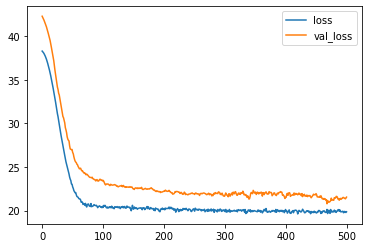

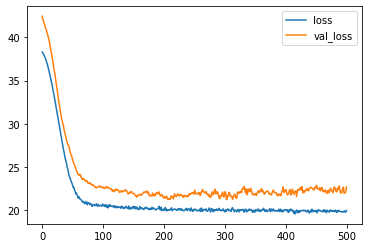

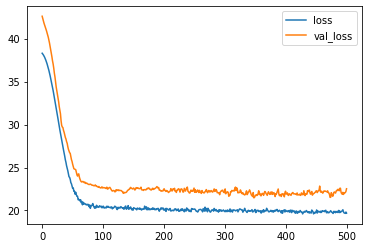

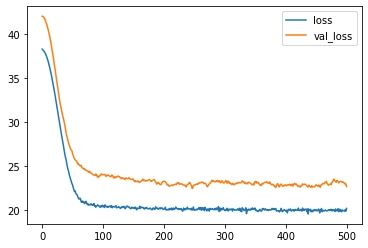

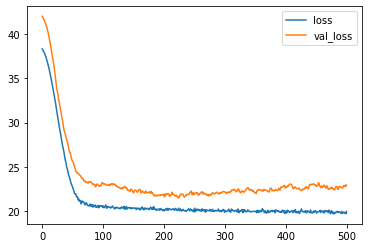

In [28]:
for i in pca_dims:

    # Let's try making a Neural Network as well!
    early_stopping = EarlyStopping(
        min_delta=0.001, # minimium amount of change to count as an improvement
        patience=20, # how many epochs to wait before stopping
        restore_best_weights=True,
    )

    NN_model = keras.Sequential([
        #Input Layer to layer 1
        layers.Dense(8, activation='relu', input_shape=[30]),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        #Layer 2
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        #Layer 3
        layers.Dense(8, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        #Output Layer
        layers.Dense(1),
    ])

    NN_model.compile(
        optimizer='adam',
        loss='mae',
    )

    history = NN_model.fit(
        X_pca, train_y,
        validation_data=(X_pca_val, val_y),
        batch_size= 190,
        epochs=500,
        verbose = 1
    )

    #Plot history
    history_df = pd.DataFrame(history.history)
    print(history_df.loc[:, ['loss', 'val_loss']].plot());
    print(history_df)

This is basically the same no matter what dimension we use